# Extending Hastings' thresholding algorithm

This was initially proposed in https://arxiv.org/pdf/1905.07047.pdf as a classical competitor to QAOA for MaxCut.

It works on D-regular, N-node graphs as follows:
* Randomly assign a spin (±1) to each node.
* For each spin, if at least T / D neighbors have the same spin, flip the spin.
* The number of cuts in MaxCut is the number of edges ($0\le K \le DN/2$) that have nodes with different spins. 


Hastings defines performance $-0.5 \le \delta \le 0.5$ compared to a random partitioning of equal size, which on average would cut half the edges:
$$
K = (1/2 + \delta)(DN/2)
$$

Optimizing threshold T for each D almost always outperforms 1-step QAOA on D-regular triangle-free graphs, but with the same scaling $\delta \propto D^{-0.5}$.


---

## Goal 1: Reproduce Hastings' numerical performance results for MaxCut.

This was completed on July 7 2020.

Hastings analyzes a subgraph of node $i$ and $j$ and their other neighbors. He defines the following functions:
* $q(k)$ decides whether or not to "flip the spin". Here, $k$ is the number of neighbors with same spin. $q(k) = -1$ if $k \ge T$, otherwise $+1$.
* $P_n(k)$ is the binomial probability distribution ${n \choose k}2^{-n}$, given $n$ neighbors not including $j$. In Hastings' analysis, $n=D-1$.

Hastings computes the correlation function $\langle Z_i Z_j \rangle$, where $Z_l$ is the spin $\pm 1$ of node $l$. $\langle Z_i Z_j \rangle$ is the chance the nodes have the same spin (+1), subtracting the chance the nodes have opposite spin (-1). Thus, $1/2(1 - \langle Z_i Z_j \rangle)$ is 1 if the nodes have opposite spin, and 0 if the nodes have the same spin.

Since all subgraphs are identical, one can use linearity of expectation to count the number of edges to cut:
$$
K = (DN/2)(1/2)(1 - \langle Z_i Z_j \rangle)
$$

So, the performance $\delta = (-1/2)\langle Z_i Z_j \rangle$.

Hastings conducts the analysis for triangle-free graphs. Nodes $i$ and $j$ agree in spin with 1/2 chance. The below formulas show how $Z_i$ and $Z_j$ will update.
* If they do agree, $Z_i = Z_j = (\sum_{k=0}^{d-1} P_{d-1}(k) q(k+1))$. 
* If not,  $Z_i = - Z_j = (\sum_{k=0}^{d-1} P_{d-1}(k) q(k))$

So, we can compute $\langle Z_i Z_j \rangle$:
$$
\langle Z_i Z_j \rangle = 1/2 (\sum_{k=0}^{d-1} P_{d-1}(k) q(k+1))^2 - 1/2 (\sum_{k=0}^{d-1} P_{d-1}(k) q(k))^2
$$



### Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

In [2]:
def qsimple(k, threshold):
    return -1 if k >= threshold else 1

def q(k, threshold):
    """Like qsimple above, but also works for numpy arrays"""
    return (1-(k >= threshold)*2)

def test_qs():
    """Test q and qsimple methods"""
    assert q(2, 3) ==  1 == qsimple(2, 3), "testing q less than threshold"
    assert q(3, 3) == -1 == qsimple(3, 3), "testing q equal to threshold"
    assert q(3, 2) == -1 == qsimple(3, 2), "testing q higher than threshold"
    assert np.all(q(np.array([2,3,4]), 3) == np.array([1, -1, -1])), "list of q"
    assert np.all(q(np.array([2,3,4]), 3) == [qsimple(2, 3), qsimple(3,3), qsimple(4,3)]), "list of q"
    
test_qs()

In [3]:
def calc_performance(D, T):
    """
    This calculates the performance over random after 1 step of Hastings' thresholding algorithm. 
    Precisely, returns delta = -1/2 <Z_i Z_j> for D-regular graphs with threshold T.
    """
    s1 = 0
    s2 = 0
    # go through # of agreeing neighbors, from 0 through D-1
    for i in range(D):
        # factor out two copies of 2^-n, n=D-1
        s1 += binom(D-1, i)*q(i+1, T)
        s2 += binom(D-1, i)*q(i, T)
    return -0.5 * 0.5 * (s1**2 - s2**2) * 2**(-2*(D-1))

In [4]:
def test_all_thresholds(D, fn):
    """
    Gets performance over random for all possible thresholds (from 0 through D+1).
    Returns all results.
    """
    return [fn(D, T) for T in range(D+2)]

def print_max(D, results):
    """Finds and prints out the maximum performance in the input list."""
    print("D =", D, "T =", results.index(max(results)), "performance =", max(results))
    
def plot_by_T(D, results, label_prefix=""):
    plt.plot(range(len(results)), results, label=label_prefix + "D=" + str(D))
    plt.xlabel("min threshold to switch")
    plt.ylabel("performance $\delta$")

### Plots
This plots performance by chosen threshold. The maximum value should match Table 1 in Hastings' paper. Notice that performance vs T is a shifted odd function.

D = 2 T = 2 performance = 0.25
D = 3 T = 3 performance = 0.1875
D = 4 T = 3 performance = 0.140625
D = 5 T = 4 performance = 0.15625
D = 6 T = 5 performance = 0.1220703125
D = 7 T = 5 performance = 0.128173828125
D = 8 T = 6 performance = 0.11663818359375
D = 9 T = 6 performance = 0.107666015625
D = 10 T = 7 performance = 0.107666015625
D = 11 T = 7 performance = 0.09252548217773438
D = 12 T = 8 performance = 0.0986623764038086
D = 13 T = 9 performance = 0.08860141038894653
D = 14 T = 9 performance = 0.09050001204013824
D = 15 T = 10 performance = 0.0853198766708374
D = 16 T = 10 performance = 0.08332019206136465
D = 17 T = 11 performance = 0.08158713206648827
D = 18 T = 11 performance = 0.07705451361835003
D = 19 T = 12 performance = 0.07778230123221874


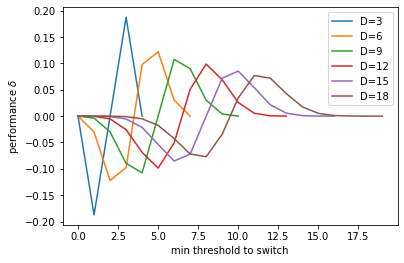

In [5]:
for D in range(2, 20):
    results = test_all_thresholds(D, calc_performance)
    print_max(D, results)
    if D % 3 == 0:
        plot_by_T(D, results)
plt.legend()

---

## Goal 2: Extend Hastings' algorithm analysis to graphs with triangles.

This was completed on July 7 2020.

### Graphs with one triangle
Consider a subgraph of nodes $i$ and $j$ and their other neighbors, where $i$ and $j$ share one other neighbor $k$.

There are four possibilities, each equally likely:
* $i, j, k$ all have the same spin. Then, $Z_i = Z_j = \sum_{k=0}^{d-2} P_{d-2}(k) q(k+2)$.
* $i, j$ share a spin opposite $k$. Then, $Z_i = Z_j =  \sum_{k=0}^{d-2} P_{d-2}(k) q(k+1)$.
* $i, k$ share a spin opposite $j$. Then, $Z_i = \sum_{k=0}^{d-2} P_{d-2}(k) q(k+1)$ and $Z_j = - \sum_{k=0}^{d-2} P_{d-2}(k) q(k)$.
* $i, j$ share a spin opposite $k$. This switches $Z_i$ and $Z_j$ in the last case.

So, we can find $\langle Z_i Z_j \rangle$:
$$
\langle Z_i Z_j \rangle = 1/4 (\sum_{k=0}^{d-2} P_{d-2}(k) q(k+2))^2 + 1/4 (\sum_{k=0}^{d-2} P_{d-2}(k) q(k+1))^2 - 1/2 (\sum_{k=0}^{d-2} P_{d-2}(k) q(k))(\sum_{k=0}^{d-2} P_{d-2}(k) q(k+1))
$$

### Code (one triangle)

In [6]:
def calc_performance_one_triangle(D, T):
    """
    This calculates the performance over random 
    after 1 step of Hastings' thresholding algorithm on a subgraph including 1 triangle.
    Precisely, returns delta = -1/2 <Z_i Z_j> for D-regular graphs with threshold T.
    """
    s1 = 0
    s2 = 0
    s3 = 0
    # go through # of agreeing neighbors, from 0 through D-2
    for i in range(D-1):
        # factor out two copies of 2^-n, n=D-2
        s1 += binom(D-2, i)*q(i+2, T)
        s2 += binom(D-2, i)*q(i+1, T)
        s3 += binom(D-2, i)*q(i, T)
    return -0.5 * 0.25 * (s1**2 + s2**2 - 2*s2*s3) * 2**(-2*(D-2))

### Plots (one triangle vs triangle-free)

Notice that the maximum performance is slightly reduced when adding one triangle. 

Perhaps it is because $j$ is slightly more likely to be "in sync" with $i$; i.e. they will share switch/stay behavior if they share many neighbors.

It is also interesting that the minimum performance is also slightly reduced. (Why?)

D = 10 T = 7 performance = 0.107666015625
D = 10 T = 7 performance = 0.09271240234375


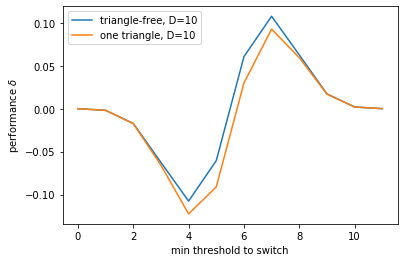

In [7]:
D=10
results = test_all_thresholds(D, calc_performance)
print_max(D, results)
plot_by_T(D, results, "triangle-free, ")

results = test_all_thresholds(D, calc_performance_one_triangle)
print_max(D, results)
plot_by_T(D, results, "one triangle, ")

plt.legend()

### Y triangles

Consider a subgraph with nodes $i,j$ and their other neighbors, where $i$ and $j$ share $0\le Y \le D-1$ other neighbors $k_1, k_2, ..., k_Y$.

I can describe this generally by considering $0 \le l \le Y$ of the shared neighbors agreeing with $i$'s spin.

* If $j$'s spin matches $i$'s spin, $Z_i = Z_j = \sum_{k=0}^{D-1-Y} P_{D-1-Y}(k) q(k+l + 1)$.
* Otherwise, $Z_i = \sum_{k=0}^{D-1-Y} P_{D-1-Y}(k) q(k+l)$ and $Z_j = - \sum_{k=0}^{D-1-Y} P_{D-1-Y}(k)q(k + Y-l)$.

So, we can write down $\langle Z_i Z_j \rangle$:
$$
\langle Z_i Z_j \rangle = \sum_{l=0}^Y 1/2 P_Y(l)f(D, Y, l)
$$
$$
f(D, Y, l) = \big( \sum_{k=0}^{D-1-Y} P_{D-1-Y}(k) q(k+l+1) \big)^2  
-  \big( \sum_{k=0}^{D-1-Y} P_{D-1-Y}(k) q(k+l) \big)\big( \sum_{k=0}^{D-1-Y} P_{D-1-Y}(k) q(k+Y-l) \big )
$$
This formula matches the above $Y=0$ and $Y=1$ formulas.




In [8]:
def calc_performance_y_triangles(D, T, Y):
    """
    This calculates the performance over random 
    after 1 step of Hastings' thresholding algorithm on a subgraph including Y triangles.
    Precisely, returns delta = -1/2 <Z_i Z_j> for D-regular graphs with threshold T.
    """
    p_k_vec = binom(D-1-Y, range(D-Y))
    out = 0
    for l in range(0, Y+1):
        q_kl1_vec = q(np.array(range(l+1, D-Y + l+1)), T)
        q_kl_vec = q(np.array(range(l, D-Y + l)), T)
        q_kyl_vec = q(np.array(range(Y-l, D-Y + Y-l)), T)
        f_dyl = sum(p_k_vec * q_kl1_vec)**2 - sum(p_k_vec * q_kl_vec)*sum(p_k_vec * q_kyl_vec)
        out += (f_dyl*binom(Y, l))
    # add powers of 2 at the end
    return -0.5 * 0.5 * out * 2**(-Y) * 2**((-2*(D-1-Y)))

In [9]:
def test_y_triangles_formula():
    """Tests Y triangle formula against 0 and 1 triangle formula."""
    assert calc_performance(5, 2) == calc_performance_y_triangles(5, 2, 0)
    assert calc_performance(5, 5) == calc_performance_y_triangles(5, 5, 0)
    assert calc_performance_one_triangle(5, 2) == calc_performance_y_triangles(5, 2, 1)

test_y_triangles_formula()

In [10]:
def calc_performance_y_triangles_curried(Y):
    """Creates a 2-argument function given number of triangles Y."""
    return lambda d, t: calc_performance_y_triangles(d, t, Y)

### Plots (triangle-free vs many triangles)

This confirms that the triangle-free results match the general results for Y=0.

D = 8 T = 6 performance = 0.11663818359375
D = 8 T = 6 performance = 0.11663818359375


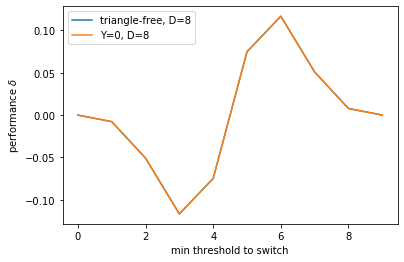

In [11]:
D=8
results = test_all_thresholds(D, calc_performance)
print_max(D, results)
plot_by_T(D, results, "triangle-free, ")

results = test_all_thresholds(D, calc_performance_y_triangles_curried(0))
print_max(D, results)
plot_by_T(D, results, "Y=0, ")

plt.legend()

This confirms that the one-triangle results match the general results for Y=1.

D = 8 T = 6 performance = 0.1007080078125
D = 8 T = 6 performance = 0.1007080078125


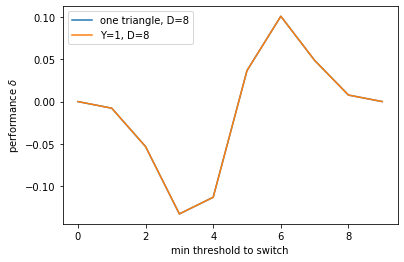

In [12]:
D=8
results = test_all_thresholds(D, calc_performance_one_triangle)
print_max(D, results)
plot_by_T(D, results, "one triangle, ")

results = test_all_thresholds(D, calc_performance_y_triangles_curried(1))
print_max(D, results)
plot_by_T(D, results, "Y=1, ")

plt.legend()

The more triangles shared by $i$ and $j$, the worse the performance. I think it is because the spin update of $i$ and $j$ are more influenced by the shared nodes than by the edge $E_{ij}$.

D = 12 T = 8 performance = 0.0986623764038086
D = 12 T = 8 performance = 0.08471488952636719
D = 12 T = 8 performance = 0.07089614868164062
D = 12 T = 8 performance = 0.0571441650390625
D = 12 T = 9 performance = 0.05065155029296875
D = 12 T = 9 performance = 0.044830322265625
D = 12 T = 9 performance = 0.03826904296875
D = 12 T = 9 performance = 0.03076171875
D = 12 T = 9 performance = 0.02197265625
D = 12 T = 9 performance = 0.01123046875
D = 12 T = 10 performance = 0.005126953125
D = 12 T = 0 performance = -0.0


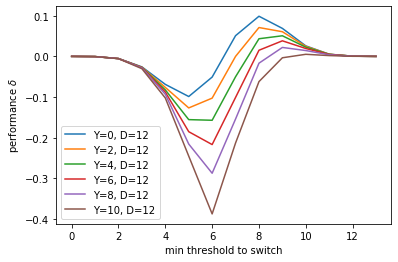

In [13]:
D=12
# from 0 through D-1 possible triangles
ys_to_plot = range(D)

for (results, y) in [(test_all_thresholds(D, calc_performance_y_triangles_curried(y)), y) for y in ys_to_plot]:
    print_max(D, results)
    if y % 2 == 0:
        plot_by_T(D, results, "Y=" + str(y) + ", ")
plt.legend()

The maximum performance decreases when adding triangles for all D.

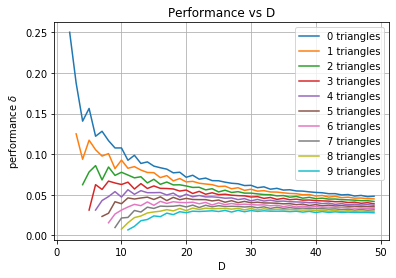

In [14]:
for y in range(10):
    ds = range(2+y, 50)
    fn = calc_performance_y_triangles_curried(y)
    deltas = [max(test_all_thresholds(d, fn)) for d in ds]
    plt.plot(ds, deltas, label=str(y) + " triangles")
plt.title("Performance vs D")
plt.xlabel("D")
plt.ylabel("performance $\delta$")
plt.legend()
plt.grid(True)

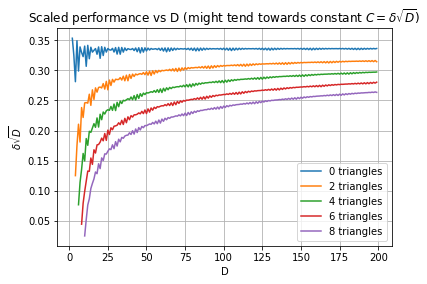

In [15]:
for y in range(0, 10, 2):
    ds = range(2+y, 200)
    fn = calc_performance_y_triangles_curried(y)
    cs = [d**0.5*max(test_all_thresholds(d, fn)) for d in ds]
    plt.plot(ds, cs, label=str(y) + " triangles")
plt.title("Scaled performance vs D (might tend towards constant $C = \delta \sqrt{D}$)")
plt.xlabel("D")
plt.ylabel("$\delta \sqrt{D}$")
plt.legend()
plt.grid(True)

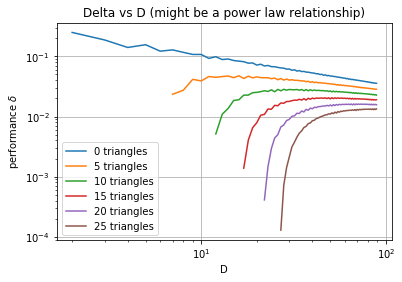

In [16]:
for y in range(0, 30, 5):
    ds = range(2+y, 90)
    fn = calc_performance_y_triangles_curried(y)
    deltas = [max(test_all_thresholds(d, fn)) for d in ds]
    plt.loglog(ds, deltas, label=str(y) + " triangles")
plt.title("Delta vs D (might be a power law relationship)")
plt.xlabel("D")
plt.ylabel("performance $\delta$")
plt.legend()
plt.grid(True)

---

## Goal 3: Compare Hastings algorithm with QAOA on non-triangle-free graphs.
* See QAOA.ipynb for the analysis extending QAOA.
* I need to see if I can improve my grid-search approach to optimize QAOA angles.
* I want to draw plots to graph the two results together (perhaps for small D), and draw conclusions.


---

## Goal 4: Extend Hastings' algorithm analysis to p=2 for (n+1)-regular graphs, girth > 4

Suppose $Z_{i0} = 1, Z_{j0} = 1$.

Suppose $k/n$ other neighbors of $i$ initially agree with $Z_i$

Suppose $u/n$ other neighbors of $j$ agree with $Z_j$.

Then, $Z_{i1,k} = q(k+1)$ and $Z_{j1,u} = q(u+1)$  (which could be $\pm 1$ depending on the threshold).

The average spin of a neighbor of $i$ (or $j$) is $Z_{1,+} = (+1)\sum_{m=0}^n P_n(m) q(m+1)$ if they initially agreed with $i$ (or $j$), or $Z_{1,-} = (-1) \sum_{m=0}^n P_n(m) q(m)$ if they didn't agree initially.

Since the actual spin can only be $\pm 1$, let's define the following:
* $p_+ = P(Z_{1,+} = 1) = (1 + Z_{1,+}) / 2$
* $p_- = P(Z_{1,-} = 1) = (1 + Z_{1,-}) / 2$
* $P1^+_k(l) =  p_+^l (1-p_+)^{k-l} {k \choose l}$
* $P1^-_k(l) = p_-^l (1-p_-)^{k-l} {k \choose l}$
* $H(k,l,r) = P1^+_k(l)P1^-_{n-k}(r)$

$H(k,l,r)$ describes the chance of $l+r$ neighbors agreeing with you, given $k/n$ initially agreeing with you. 

### F1
Suppose $q(k+1) = 1$ and $q(u+1) = 1$ (both under threshold).

Then:
$$
Z_{i2,k} = \sum_{l=0}^k \sum_{r=0}^{n-k} H(k,l,r) q(l+r+1)
$$

$$
Z_{j2,u} = \sum_{l=0}^u \sum_{r=0}^{n-u} H(u,l,r)q(l+r+1)
$$

### F2
Suppose instead $q(k+1) = -1$ and $q(u+1) = -1$.

Then:
$$
Z_{i2,k} = (-1) \sum_{l=0}^k \sum_{r=0}^{n-k} H(k,l,r) q(n-l-r+1)
$$

There are $l+r$ neighbors with spin $+1$, so $n-l-r$ neighbors with spin matching $Z_{i1}$, plus $1$ because $Z_{i1} = Z_{j1}$. Similarly,

$$
Z_{j2,u} = (-1) \sum_{l=0}^u \sum_{r=0}^{n-u} H(u,l,r)q(n-l-r+1)
$$


### F3
Suppose instead $q(k+1) = 1$ and $q(u+1) = -1$.

Then:
$$
Z_{i2,k} = \sum_{l=0}^k \sum_{r=0}^{n-k} H(k,l,r) q(l+r)
$$
$$
Z_{j2,u} = (-1) \sum_{l=0}^u \sum_{r=0}^{n-u} H(u,l,r)q(n-l-r)
$$

This is very similar to previous cases, but without $1$ since $Z_{i1} \ne Z_{j1}$. 

In the reverse case F4, we can exchange $Z_i$ with $Z_j$.

### General

We can define $Q$ to handle the different cases:
$$
Q(l,r, A, B) = q\big( (n-l-r)(1-A)/2 + (l+r)(1+A)/2 + (1 + B)/2)\big)
$$

Then:

$$
Z_{i2,k} = Z_{i1} \sum_{l=0}^k \sum_{r=0}^{n-k} H(k,l,r) Q(l,r,Z_{i1}Z_{i0}, Z_{i1}Z_{j1})
$$

$$
Z_{j2,u} = Z_{j1} \sum_{l=0}^u \sum_{r=0}^{n-u} H(u,l,r) Q(l,r,Z_{j1}Z_{j0}, Z_{j1}Z_{i1})
$$

$Q$ will use $l+r$ if $A = 1$ (i.e. under threshold), otherwise $n-l-r$. It will add one iff B = 1, i.e. $Z_{i1} = Z_{j1}$.

In sum:

$$
\langle Z_i Z_j \rangle_2 = \sum_{k=0}^n \sum_{u=0}^n P_n(k) P_n(u) Z_{i2,k} Z_{j2,u}
$$

This equation is symmetric; if $Z_{i0} = Z_{j0} = -1$, the result is the same.

### $ Z_{i0} \ne Z_{j0}$ 

Suppose that $Z_{j0} = -1$, and still $u/n$ of its other neighbors agree with $j$.

Then, $Z_{i1} = q(k)$, and $Z_{j1} = -q(u)$.

Then, the above expressions for $Z_{i2,k}, Z_{j2,u}, \langle Z_i Z_j \rangle_2$ still hold. 

This equation is symmetric; if $Z_{i0} = -1$ and $Z_{j0} = -1$, the result is the same.

It is equally likely for $i$ and $j$ to initially agree or disagree. 

All together, 

$$
\langle Z_i Z_j \rangle_2 = \sum_{k=0}^n \sum_{u=0}^n P_n(k) P_n(u) 
0.5\big(Z_{i2,k} Z_{j2,u}\Big\rvert_{Z_{i1} = q(k+1),Z_{j1} = q(u+1),Z_{i0}=Z_{j0} = 1} + Z_{i2,k} Z_{j2,u}\Big\rvert_{Z_{i1} = q(k),Z_{j1} = -q(u), Z_{i0}=1, Z_{j0} = -1}\big)
$$

## Goal 5: Plot p=2 Hastings algorithm results, over $T_1$ and $T_2$

First, assume the threshold is the same each time.


In [17]:
%whos

Variable                               Type        Data/Info
------------------------------------------------------------
D                                      int         12
binom                                  ufunc       <ufunc 'binom'>
calc_performance                       function    <function calc_performance at 0x7fd15025b320>
calc_performance_one_triangle          function    <function calc_performanc<...>iangle at 0x7fd14434fa70>
calc_performance_y_triangles           function    <function calc_performanc<...>angles at 0x7fd1442ec7a0>
calc_performance_y_triangles_curried   function    <function calc_performanc<...>urried at 0x7fd1442ec830>
cs                                     list        n=190
deltas                                 list        n=63
ds                                     range       range(27, 90)
fn                                     function    <function calc_performanc<...>ambda> at 0x7fd1443118c0>
np                                     module      <mo

In [18]:
import functools

In [19]:
def make_qfn(T):
    return lambda x: 1 if x < T else -1

qfns = [make_qfn(T) for T in range(10000)]

In [96]:
@functools.lru_cache(maxsize=4096)
def Z1plus(T, n):
    qf = qfns[T]
    return 2**(-n)*sum([binom(n, m)*qf(m+1) for m in range(0, n+1)])

@functools.lru_cache(maxsize=4096)
def Z1minus(T, n):
    qf = qfns[T]
    return (-1)*2**(-n)*sum([binom(n, m)*qf(m) for m in range(0, n+1)])

@functools.lru_cache(maxsize=4096)
def H(T, n, k,l,r):
    p_plus = (1 + Z1plus(T, n))/2
    p_minus = (1 + Z1minus(T, n))/2
    return p_plus**l * (1 - p_plus)**(k-l) * binom(k, l) * p_minus**r * (1 - p_minus)**(n-k-r) * binom(n-k, r)

@functools.lru_cache(maxsize=4096)
def bigQ(T, n, l, r, a, b):
    qf = qfns[T]
    return qf((n-l-r)*(1-a)/2 + (l+r)*(1+a)/2 + (1+b)/2)

In [97]:
@functools.lru_cache(maxsize=4096)
def Z2(Z1, Z0, match, T1, T2, n, k):
    out = 0
    for l in range(k+1):
        for r in range(n-k+1):
            out += H(T1, n, k, l, r)*bigQ(T2, n, l, r, Z1*Z0, match)
    return Z1*out

In [114]:
@functools.lru_cache(maxsize=4096)
def final(n, T1, T2):
    """
    Calculates -1/2 * <Z_i Z_j>
    """
    out = 0
    q1 = qfns[T1]
    for k in range(n+1):
        for u in range(n+1):
            equal = Z2(q1(k+1), 1, q1(k+1)*q1(u+1), T1, T2, n, k) * Z2(q1(u+1), 1, q1(k+1)*q1(u+1), T1, T2, n, k)
            unequal = Z2(q1(k), 1, -q1(k)*q1(u), T1, T2, n, k) * Z2(-q1(u), -1, -q1(k)*q1(u), T1, T2, n, k)
            out += binom(n, k) * binom(n, u) * 0.5 * (equal + unequal)
    return -0.5 * 2**(-2*n) * out

It should be odd function over the midpoint. Both T=0 and T> n+1 should be 0 (i.e. no improvement).

In [99]:
import time

In [100]:
# ! pip install line-profiler
# %load_ext line_profiler

In [101]:
# %lprun -f final final(70, makeq(3), makeq(3))

CPU times: user 1.76 s, sys: 3.92 ms, total: 1.76 s
Wall time: 1.77 s


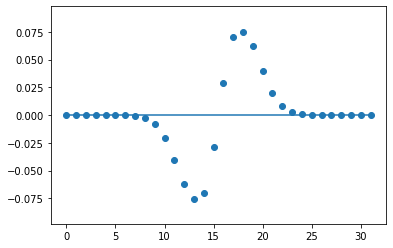

In [107]:
%%time
# recall that n = D-1
D=30
xs = range(D+2)
plt.scatter(xs, [final(D-1, t, t) for t in xs])
plt.plot(xs, [0]*len(xs))

In [108]:
def get_max_final(d):
    return max([final(d-1, t, t) for t in range(d+2)])

In [109]:
get_max_final(3)

0.191162109375

performance is decent until about n=60 it takes ~1s per data point

The cache might be acting weird - on first run the first few D values were missing

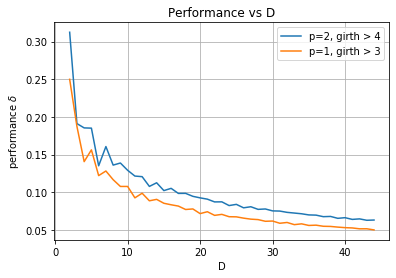

In [118]:
ds = range(2, 45)
deltas = [get_max_final(d) for d in ds]
plt.plot(ds, deltas, label="p=2, girth > 4")

fn = calc_performance_y_triangles_curried(0)
deltas = [max(test_all_thresholds(d, fn)) for d in ds]
plt.plot(ds, deltas, label="p=1, girth > 3")

plt.title("Performance vs D")
plt.xlabel("D")
plt.ylabel("performance $\delta$")
plt.legend()
plt.grid(True)

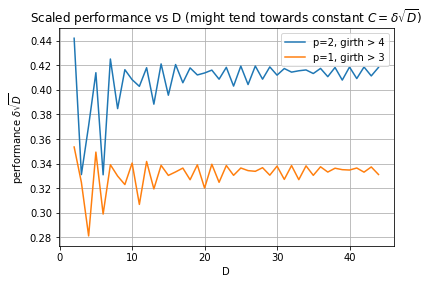

In [117]:
ds = range(2, 45)
deltas = [d**0.5 * max([final(d-1, t, t) for t in range(d+2)]) for d in ds]
plt.plot(ds, deltas, label="p=2, girth > 4")

fn = calc_performance_y_triangles_curried(0)
cs = [d**0.5*max(test_all_thresholds(d, fn)) for d in ds]
plt.plot(ds, cs, label="p=1, girth > 3")

plt.title("Scaled performance vs D (might tend towards constant $C = \delta \sqrt{D}$)")
plt.xlabel("D")
plt.ylabel("performance $\delta \sqrt{D}$")
plt.legend()
plt.grid(True)